<a href="https://colab.research.google.com/github/rahmanidashti/FairBook/blob/main/FairBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook should be run on Google Colab

In [ ]:
# import
import os
import random as rd
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import time
from tqdm import tqdm

## Settings

In [ ]:
# constants and initialization
item_threshold = 1 # 1 means no filtering
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
predict_col = 'bid'
top_fraction = 0.2
feedback_column = 'rating'
user_events_file = "https://raw.githubusercontent.com/rahmanidashti/FairBook/main/dataset/Bookcrossing/BX-Book-Explicit-5Rate-Map.csv"
high_user_file = "https://raw.githubusercontent.com/rahmanidashti/FairBook/main/dataset/Bookcrossing/user-groups/active_users.txt"
low_user_file = "https://raw.githubusercontent.com/rahmanidashti/FairBook/main/dataset/Bookcrossing/user-groups/inactive_users.txt"
medium_user_file = "https://raw.githubusercontent.com/rahmanidashti/FairBook/main/dataset/Bookcrossing/user-groups/medium_users.txt"

## Load Dataset

In [ ]:
# read user events
df_events = pd.read_csv(user_events_file, sep=',')
print('No. of user interactions: ' + str(len(df_events)))

No. of user interactions: 88552


In [ ]:
df_events.head()

,uid,bid,rating
0,0,0,8
1,0,1,10
2,0,2,10
3,0,3,10
4,0,4,10


In [ ]:
df_events = df_events[df_events[feedback_column] >= item_threshold]
print('No. filtered user interactions: ' + str(len(df_events)))
print('No. filtered items: ' + str(len(df_events[predict_col].unique())))

No. filtered user interactions: 88552
No. filtered items: 6921


## User-Item Analysis

In [ ]:
# get user distribution
user_dist = df_events['uid'].value_counts()
num_users = len(user_dist)
print('No. users: ' + str(num_users))
print('Mean books per user: ' + str(user_dist.mean()))
print('Min books per user: ' + str(user_dist.min()))
print('Max books per user: ' + str(user_dist.max()))

No. users: 6358
Mean books per user: 13.927650204466813
Min books per user: 5
Max books per user: 153


In [ ]:
# get item distribution
item_dist = df_events['bid'].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))

No. items: 6921


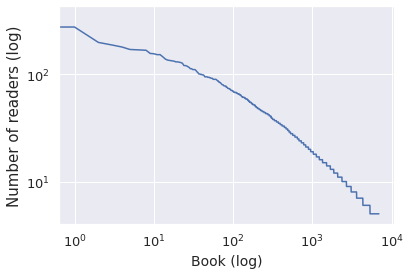

In [ ]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('Book (log)', fontsize='14')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Number of readers (log)', fontsize='15')
plt.xscale('log')
plt.yscale('log')
plt.savefig('book_long_tail_log.pdf', dpi=300, bbox_inches='tight')

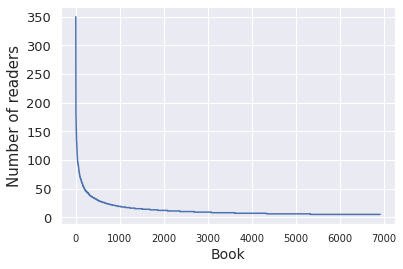

In [ ]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('Book', fontsize='14')
plt.xticks(fontsize='10')
plt.yticks(fontsize='13')
plt.ylabel('Number of readers', fontsize='15')
plt.savefig('book_long_tail_normal.pdf', dpi=300, bbox_inches='tight')

In [ ]:
# get top items
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 1384


## User Groups Analysis

In [ ]:
# read users
low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')

no_users = len(low_users) + len(medium_users) + len(high_users)

print('No. of users: ' + str(no_users))
print('No. of inactive users: ' + str(len(low_users)))
print('No. of medium users: ' + str(len(medium_users)))
print('No. of active users: ' + str(len(high_users)))

No. of users: 6358
No. of inactive users: 1271
No. of medium users: 3816
No. of active users: 1271


In [ ]:
# get pop fractions
predict_col = 'bid'

pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles

low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0

low_count = 0
med_count = 0
high_count = 0

for u, df in df_events.groupby('uid'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    else:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1

low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)

low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)

print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

Low count (for check): 1271
Med count (for check): 3816
High count (for check): 1271


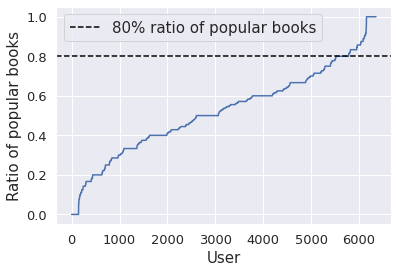

In [ ]:
plt.figure()
plt.plot(sorted(pop_fraq))
plt.xlabel('User', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Ratio of popular books', fontsize='15')
plt.yticks(fontsize='13')
plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular books')
plt.legend(fontsize='15')
plt.savefig('user_book_ratio.pdf', dpi=300, bbox_inches='tight')

R-value: 0.9228233272832902


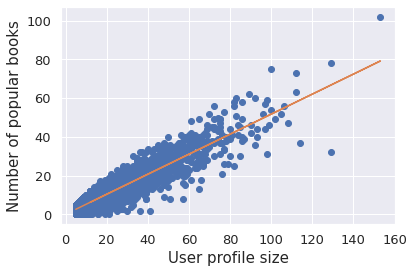

In [ ]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_count)
print('R-value: ' + str(r_value))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_count, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='15')
plt.xticks(fontsize='13')
plt.ylabel('Number of popular books', fontsize='15')
plt.yticks(fontsize='13')
plt.savefig('corr_user_pop.pdf', dpi=300, bbox_inches='tight')

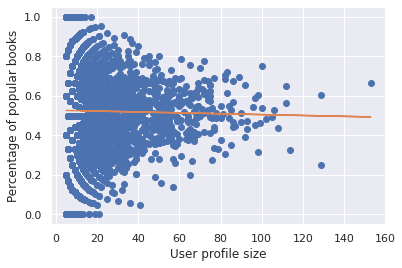

In [ ]:
# we can remore it and do not use it
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_fraq)
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_fraq, 'o', user_hist, line)
plt.xlabel('User profile size')
plt.ylabel('Percentage of popular books')
plt.savefig('corr_user_ratio.pdf', dpi=300, bbox_inches='tight')

R-value: -0.0335752222262517
SpearmanrResult(correlation=0.06291508367304682, pvalue=5.149636716688308e-07)


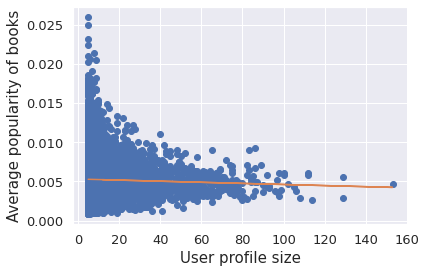

In [ ]:
plt.figure()
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_item_fraq)
print('R-value: ' + str(r_value))
print(stats.spearmanr(user_hist, pop_item_fraq))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_item_fraq, 'o', user_hist, line)
plt.xlabel('User profile size', fontsize='15')
plt.ylabel('Average popularity of books', fontsize='15')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.savefig('corr_user_avg.pdf', dpi=300, bbox_inches='tight')

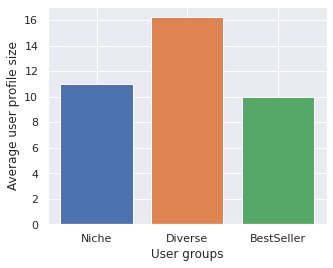

In [ ]:
sns.set(rc = {'figure.figsize':(5,4)})

# set plot style: grey grid in the background:
sns.set(style="darkgrid")
plt.figure()
plt.bar(0, low_profile_size)
plt.bar(1, medium_profile_size)
plt.bar(2, high_profile_size)
plt.xticks(np.arange(3), ['Niche', 'Diverse', 'BestSeller'])
plt.xlabel('User groups')
plt.ylabel('Average user profile size')
plt.savefig('group_size.pdf', dpi=300, bbox_inches='tight')

In [ ]:
print('Average LowMS profile size: ' + str(low_profile_size))
print('Average MedMS profile size: ' + str(medium_profile_size))
print('Average HighMS profile size: ' + str(high_profile_size))

Average LowMS profile size: 11.019669551534225
Average MedMS profile size: 16.21829140461216
Average HighMS profile size: 9.958300550747444


## Recommendation using Cornac

In [ ]:
# install cornac framework for RecSys
! pip install cornac

     |████████████████████████████████| 12.4 MB 14.6 MB/s 


### Switch to Tensorflow 1

In [ ]:
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [ ]:
import tensorflow as tf
tf.__version__

'2.2.0'

### Import Cornac Reqired Packages

In [ ]:
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF, NMF
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR

In [ ]:
# load txt file to feed into Cornac
os.system("wget https://raw.githubusercontent.com/rahmanidashti/FairBook/main/dataset/Bookcrossing/BX-Book-Explicit-5Rate-Map.txt")

0

In [ ]:
# load dataset in Cornac
reader = Reader()
data = reader.read('BX-Book-Explicit-5Rate-Map.txt', fmt='UIR', sep=',')

In [ ]:
# Split the data based on ratio
rs = RatioSplit(data=data, test_size=0.2, rating_threshold=1.0, seed=123)

In [ ]:
# initialize models, here we are comparing: simple, traditional, and neural networks based models
models = [
          # 1: Random
          # 2: MostPop
          MostPop(),
          # 3: UserKNN
          # 4: BPR
          BPR(k=10, max_iter=200, learning_rate=0.001, lambda_reg=0.01, seed=123),
          # 5: MF
          MF(k=30, max_iter=100, learning_rate=0.01, lambda_reg=0.001, seed=123),
          # 6: PMF
          PMF(k=10, max_iter=100, learning_rate=0.001, lambda_reg=0.001),
          # 7: NMF
          NMF(k=15, max_iter=50, learning_rate=0.005, lambda_u=0.06, lambda_v=0.06, lambda_bu=0.02, lambda_bi=0.02, use_bias=False, verbose=True, seed=123),
          # 8: WMF
          WMF(k=50, max_iter=50, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01, verbose=True, seed=123),
          # 9: PF
          HPF(k=50, seed=123, hierarchical=False, name="PF"),
          # 10: NueMF
          NeuMF(num_factors=8, layers=[32, 16, 8], act_fn="tanh", num_epochs=1, num_neg=3, batch_size=256, lr=0.001, seed=42, verbose=True),
          # 11: VAECF
          VAECF(k=10, autoencoder_structure=[20], act_fn="tanh", likelihood="mult", n_epochs=100, batch_size=100, learning_rate=0.001, beta=1.0, seed=123, use_gpu=True, verbose=True)
          ]

In [ ]:
# define metrics to evaluate the models
metrics = [MAE(), MSE(), RMSE(), AUC(), MAP(), MRR(), 
           Precision(k=5), Precision(k=10), Precision(k=20), Precision(k=50),
           Recall(k=5), Recall(k=10), Recall(k=20), Recall(k=50),
           NDCG(k=5), NDCG(k=10), NDCG(k=20), NDCG(k=50),
           FMeasure(k=5), FMeasure(k=10), FMeasure(k=20), FMeasure(k=50)]

# put it together in an experiment, voilà!
exp = cornac.Experiment(eval_method=rs, models=models, metrics=metrics, user_based=True)
exp.run()

In [ ]:
def compute_user_knn(C):
  ctime = time.time()
  print("Training User-based Collaborative Filtering...", )

  sim = C.dot(C.T)
  norms = [norm(C[i]) for i in range(C.shape[0])]

  for i in tqdm(range(C.shape[0])):
    sim[i][i] = 0.0
    for j in range(i+1, C.shape[0]):
      sim[i][j] /= (norms[i] * norms[j])
      sim[j][i] /= (norms[i] * norms[j])

  print("Done. Elapsed time:", time.time() - ctime, "s")
  rec_score = sim.dot(C)
  return rec_score

In [ ]:
def read_training_data():
  training_matrix = np.zeros((rs.train_set.matrix.shape[0], rs.train_set.matrix.shape[1]))
  for uid in tqdm(rs.train_set.uid_map.values()):
    for iid in rs.train_set.iid_map.values():
      training_matrix[uid, iid] = rs.train_set.matrix[uid, iid]
  return training_matrix

In [ ]:
# creating users-books rating matrix (will be used for User-KNN algorithm)
training_matrix = read_training_data()

100%|██████████| 6358/6358 [20:31<00:00,  5.16it/s]


In [ ]:
# running User-KNN algorithms and getting the user-book scores
user_knn_scores = compute_user_knn(training_matrix)

Training User-based Collaborative Filtering...


100%|██████████| 6358/6358 [00:36<00:00, 173.53it/s] 


Done. Elapsed time: 45.76793646812439 s


In [ ]:
# UserKNN recommendation algorithm
def get_top_n_UserKNN(n=10):
    print("User-KNN model is selected:")
    top_n = defaultdict(list)
    # test_items = list(rs.test_set.iid_map.keys())
    for uid in rs.train_set.uid_map.values():
      user_id = list(rs.train_set.user_ids)[uid]
      top_n_items_idxs = list(reversed(user_knn_scores[uid].argsort()))[:n]
      for iid in top_n_items_idxs:
        item_id = list(rs.train_set.item_ids)[iid]
        top_n[int(user_id)].append((int(item_id), user_knn_scores[uid][iid]))
    return top_n

In [ ]:
def get_top_n(algo_name, n=10):
  for model in exp.models:
    if model.name == algo_name:
      print(model.name + " model is selected:")
      top_n = defaultdict(list)
      for uid in model.train_set.uid_map.values():
        user_id = list(model.train_set.user_ids)[uid]
        try:
          item_rank = model.rank(user_idx=uid)[0]
        except:
          item_rank = model.rank(user_idx=int(uid))[0]
        # collect top N items
        item_rank_top = item_rank[:n]
        for iid in item_rank_top:
          item_id = list(model.train_set.item_ids)[iid]
          top_n[int(user_id)].append((int(item_id), model.score(uid, iid)))
  return top_n

In [ ]:
# random recommendation algorithm
def get_top_n_random(n=10):
    print("Random model is selected:")
    top_n = defaultdict(list)
    test_items = list(rs.test_set.iid_map.keys())
    for uid in rs.train_set.uid_map.values():
      if uid not in top_n.keys():
        user_id = list(rs.train_set.user_ids)[uid]
        for i in range(0, n):
          top_n[int(user_id)].append((int(rd.choice(test_items)), i))
    return top_n

In [ ]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = [feedback_column]
df_item_dist[feedback_column] /= no_users
df_item_dist.head()

,rating
124,0.055049
70,0.043567
50,0.031299
465,0.029569
581,0.028311


In [ ]:
algo_names = ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']

i = 0
low_rec_gap_list = [] # one entry per algorithmus
medium_rec_gap_list = []
high_rec_gap_list = []

for i in range(0, len(algo_names)):
    df_item_dist[algo_names[i]] = 0
    low_rec_gap = 0
    medium_rec_gap = 0
    high_rec_gap = 0
    
    if algo_names[i] == 'Random':
      top_n = get_top_n_random(n=10)
    elif algo_names[i] == 'UserKNN':
      top_n = get_top_n_UserKNN(n=10)
    else:
      top_n = get_top_n(algo_names[i], n=10)
    low_count = 0
    med_count = 0
    high_count = 0
    for uid, user_ratings in top_n.items():
        iid_list = []
        for (iid, _) in user_ratings:
            df_item_dist.loc[iid, algo_names[i]] += 1
            iid_list.append(iid)
        gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
        if uid in low_users.index:
            low_rec_gap += gap
            low_count += 1
        elif uid in medium_users.index:
            medium_rec_gap += gap
            med_count += 1
        elif uid in high_users.index:
            high_rec_gap += gap
            high_count += 1
    low_rec_gap_list.append(low_rec_gap / low_count)
    medium_rec_gap_list.append(medium_rec_gap / med_count)
    high_rec_gap_list.append(high_rec_gap / high_count)
    i += 1 # next algorithm

Random model is selected:
MostPop model is selected:
User-KNN model is selected:
MF model is selected:
PMF model is selected:
BPR model is selected:
NMF model is selected:
WMF model is selected:
PF model is selected:
NeuMF model is selected:
VAECF model is selected:


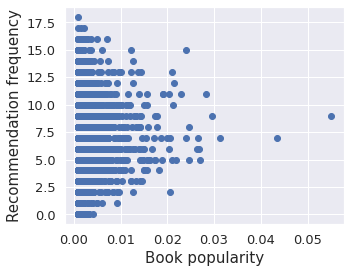

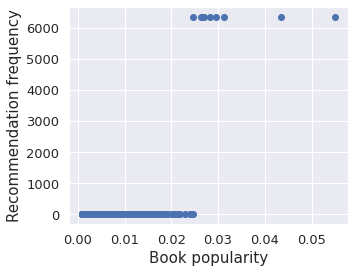

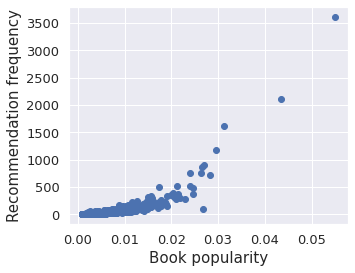

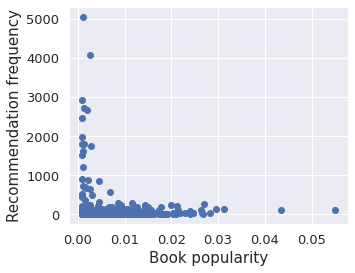

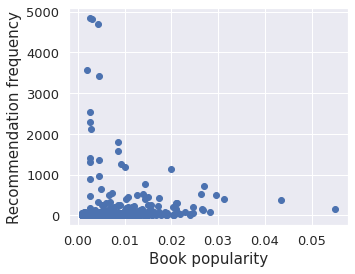

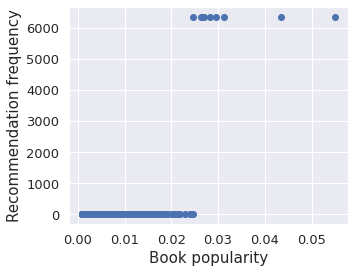

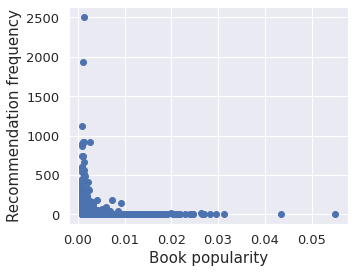

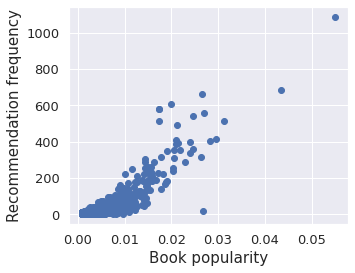

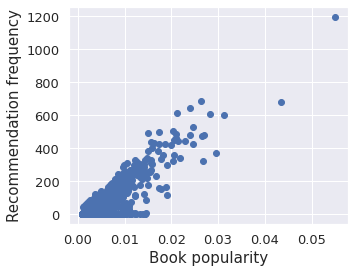

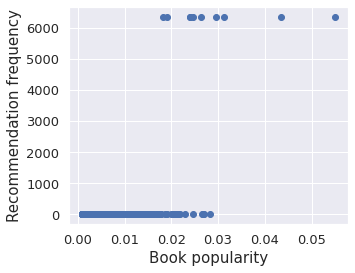

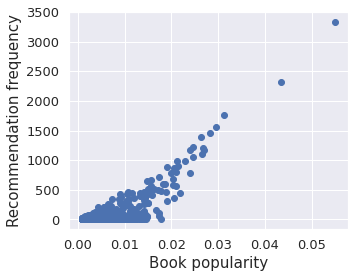

In [ ]:
sns.set(rc = {'figure.figsize':(5,4)})
for i in range(0, len(algo_names)):
    plt.figure()
    x = df_item_dist[feedback_column]
    y = df_item_dist[algo_names[i]]

    plt.plot(x, y, 'o')
    plt.xlabel('Book popularity', fontsize='15')
    plt.ylabel('Recommendation frequency', fontsize='15')
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    plt.savefig('rec_' + algo_names[i] + '.pdf', dpi=300, bbox_inches='tight')

In [ ]:
low_gap_vals = []
medium_gap_vals = []
high_gap_vals = []

for i in range(0, len(algo_names)):
    low_gap_vals.append((low_rec_gap_list[i] - low_gap) / low_gap * 100)
    medium_gap_vals.append((medium_rec_gap_list[i] - medium_gap) / medium_gap * 100)
    high_gap_vals.append((high_rec_gap_list[i] - high_gap) / high_gap * 100)

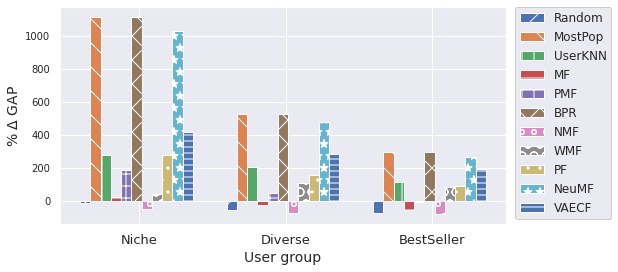

In [ ]:
sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar
bars1 = [low_gap_vals[0], medium_gap_vals[0], high_gap_vals[0]]
bars2 = [low_gap_vals[1], medium_gap_vals[1], high_gap_vals[1]]
bars3 = [low_gap_vals[2], medium_gap_vals[2], high_gap_vals[2]]
bars4 = [low_gap_vals[3], medium_gap_vals[3], high_gap_vals[3]]
bars5 = [low_gap_vals[4], medium_gap_vals[4], high_gap_vals[4]]
bars6 = [low_gap_vals[5], medium_gap_vals[5], high_gap_vals[5]]
bars7 = [low_gap_vals[6], medium_gap_vals[6], high_gap_vals[6]]
bars8 = [low_gap_vals[7], medium_gap_vals[7], high_gap_vals[7]]
bars9 = [low_gap_vals[8], medium_gap_vals[8], high_gap_vals[8]]
bars10 = [low_gap_vals[9], medium_gap_vals[9], high_gap_vals[9]]
bars11 = [low_gap_vals[10], medium_gap_vals[10], high_gap_vals[10]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
# r12 = [x + barWidth for x in r11]
# r13 = [x + barWidth for x in r12]

# ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--"]

# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random', hatch=patterns[0])
plt.bar(r2, bars2, width=barWidth, label='MostPop', hatch=patterns[1])
plt.bar(r3, bars3, width=barWidth, label='UserKNN', hatch=patterns[2])
plt.bar(r4, bars4, width=barWidth, label='MF', hatch=patterns[3])
plt.bar(r5, bars5, width=barWidth, label='PMF', hatch=patterns[4])
plt.bar(r6, bars6, width=barWidth, label='BPR', hatch=patterns[5])
plt.bar(r7, bars7, width=barWidth, label='NMF', hatch=patterns[6])
plt.bar(r8, bars8, width=barWidth, label='WMF', hatch=patterns[7])
plt.bar(r9, bars9, width=barWidth, label='PF', hatch=patterns[8])
plt.bar(r10, bars10, width=barWidth, label='NeuMF', hatch=patterns[9])
plt.bar(r11, bars11, width=barWidth, label='VAECF', hatch=patterns[10])

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('% $\Delta$ GAP', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ['Niche', 'Diverse', 'BestSeller'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.savefig('gap_analysis.pdf', dpi=300, bbox_inches='tight')

In [ ]:
# analysis on different users groups based on the NDCG@10
# reult have difference parameter and show the values of evaluation includes per user performance on each evaluation metrics

print("User groups evaluation is started ...")

niche_users = list()
divers_users = list()
focused_users = list()

metric_group_results = defaultdict(list)
metric_group_results['MAE'] = list()
metric_group_results['Precision@10'] = list()
metric_group_results['Recall@10'] = list()
metric_group_results['NDCG@10'] = list()

ttest_group_results = defaultdict(list)
ttest_group_results['MAE'] = list()
ttest_group_results['Precision@10'] = list()
ttest_group_results['Recall@10'] = list()
ttest_group_results['NDCG@10'] = list()

for eachresult in exp.result:
  print("> " + eachresult.model_name)
  user_results = eachresult.metric_user_results # <- this is a dictionary
  for metric in exp.metrics:
    for user_idx, user_performance in user_results[metric.name].items():
      user_id = int(list(rs.train_set.user_ids)[user_idx])
      if user_id in low_users.index:
        niche_users.append(user_performance)
      elif user_id in medium_users.index:
        divers_users.append(user_performance)
      elif user_id in high_users.index:
        focused_users.append(user_performance)
      else:
        print("Oops! We could not find a user!")

    print(metric.name + ": " + str(round(np.mean(niche_users), 4)) + "," + str(round(np.mean(divers_users), 4)) + "," + str(round(np.mean(focused_users), 4)))
    if metric.name in metric_group_results.keys():
      metric_group_results[metric.name].append((round(np.mean(niche_users), 4),
                                                round(np.mean(divers_users), 4),
                                                round(np.mean(focused_users), 4)))
      
      ttest_group_results[metric.name].append((round(stats.ttest_ind(niche_users, divers_users)[1], 8),
                                               round(stats.ttest_ind(niche_users, focused_users)[1], 8),
                                              round(stats.ttest_ind(divers_users, focused_users)[1], 8)))

    print(stats.ttest_ind(niche_users, focused_users))
    niche_users.clear()
    divers_users.clear()
    focused_users.clear()
  print()

User groups evaluation is started ...
> MostPop
MAE: 2.783,2.492,2.2878
Ttest_indResult(statistic=7.435886545867454, pvalue=1.5136696550071922e-13)
MSE: 11.7564,9.8648,8.5401
Ttest_indResult(statistic=7.2084482543848045, pvalue=7.90077178584305e-13)
RMSE: 3.0491,2.7949,2.4931
Ttest_indResult(statistic=8.16753585321936, pvalue=5.417120323531059e-16)
AUC: 0.4565,0.6504,0.8367
Ttest_indResult(statistic=-38.68671438668353, pvalue=9.523758201539388e-247)
MAP: 0.0039,0.0137,0.0322
Ttest_indResult(statistic=-8.944187413421709, pvalue=8.12395520430788e-19)
MRR: 0.0088,0.0377,0.0632
Ttest_indResult(statistic=-9.316096299920646, pvalue=2.9901590689904625e-20)
Precision@5: 0.0021,0.0096,0.0176
Ttest_indResult(statistic=-7.812383257669373, pvalue=8.858433085942772e-15)
Precision@10: 0.0017,0.0084,0.0128
Ttest_indResult(statistic=-9.057291314365356, pvalue=3.0144369007543546e-19)
Precision@20: 0.0015,0.0071,0.0101
Ttest_indResult(statistic=-10.999975511097023, pvalue=2.1640913669642567e-27)
Precisi

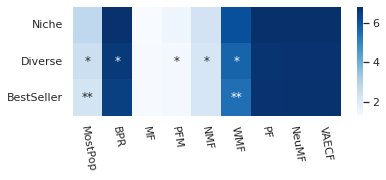

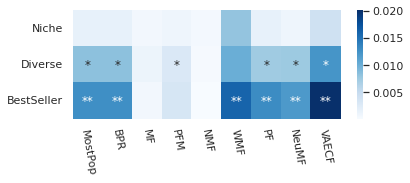

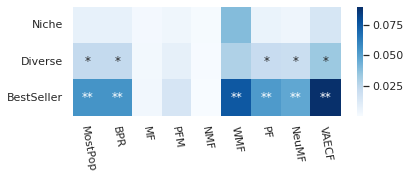

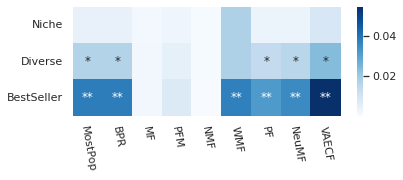

In [ ]:
sns.set(rc = {'figure.figsize':(6,2)})

for metric in ['MAE', 'Precision@10', 'Recall@10', 'NDCG@10']:
  data = [[], [], []]
  labels = [['', '', '', '', '', '', '', '', ''], [], []]

  for item in metric_group_results[metric]:
    # print(item)
    data[0].append(item[0])
    data[1].append(item[1])
    data[2].append(item[2])


  for item in ttest_group_results[metric]:
    if item[0] < 0.005:
      labels[1].append('*')
    else:
      labels[1].append('')
    if item[1] < 0.005 and item[2] < 0.005:
      labels[2].append('**')
    else:
      labels[2].append('')

  fig, ax = plt.subplots()
  ax = sns.heatmap(data, annot=labels, fmt = '', cmap="Blues")
  ax.set_xticklabels(['MostPop', 'BPR', 'MF', 'PFM', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF'])
  ax.set_yticklabels(['Niche', 'Diverse', 'BestSeller'])
  ax.tick_params(axis='x', rotation=280)
  ax.tick_params(axis='y', rotation=0)
  plt.savefig(f'{metric}_metric_analysis.pdf', dpi=300, bbox_inches='tight')